# Ciclope beam FE test
from CT image to beam-FE model solution in Calculix

Created on:  23.05.2021 <br />
Last update: 17.01.2024 <br />

- Data source: LHDL project (IOR Bologna, Italy)
- For more info on the dataset see the [LHDL homepage](http://projects.kmi.open.ac.uk/lhdl/)

For info on the solver see the [Calculix homepage](http://www.calculix.de/)

## Configuration

In [1]:
import sys
sys.path.append('./../../')

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from scipy import ndimage, misc
from skimage.filters import threshold_otsu, gaussian
from skimage.morphology import skeletonize, skeletonize_3d,  medial_axis
from skimage.util import invert
from skimage import measure, morphology
from skimage import data
import sknw

import networkx as nx

from ciclope.utils.recon_utils import read_tiff_stack, plot_midplanes, plot_projections
from ciclope.utils.preprocess import remove_unconnected
import ciclope

matplotlib.rcParams['figure.dpi'] = 300

font = {'weight' : 'normal',
        'size'   : 8}

plt.rc('font', **font)

In [3]:
# # for visualization with itkwidgets
# import itk
# from itkwidgets import view

In [4]:
# for the 3D plotting of a graph
# from mpl_toolkits.mplot3d import Axes3D

### Function definition

In [3]:
def network_plot_3D(G, angle=30, save=False):

    # Get node positions
    pos = nx.get_node_attributes(G, 'pts')
    
    # Get number of nodes
    n = G.number_of_nodes()

    # Get the maximum number of edges adjacent to a single node
    edge_max = max([G.degree(i) for i in range(n)])

    # Define color range proportional to number of edges adjacent to a single node
    colors = [plt.cm.plasma(G.degree(i)/edge_max) for i in range(n)] 

    # 3D network plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Loop on the pos dictionary to extract the x,y,z coordinates of each node
    for key, value in pos.items():
        xi = value[0][0]
        yi = value[0][1]
        zi = value[0][2]

        # Scatter plot
        ax.scatter(xi, yi, zi, c=colors[key], s=20+20*G.degree(key), edgecolors='k', alpha=0.7)

    # Loop on the list of edges to get the x,y,z, coordinates of the connected nodes
    # Those two points are the extrema of the line to be plotted
    for i,j in enumerate(G.edges()):

        x = np.array((graph.nodes[j[0]]['pts'][0][0], graph.nodes[j[1]]['pts'][0][0]))
        y = np.array((graph.nodes[j[0]]['pts'][0][1], graph.nodes[j[1]]['pts'][0][1]))
        z = np.array((graph.nodes[j[0]]['pts'][0][2], graph.nodes[j[1]]['pts'][0][2]))
        # print(z)
        
        # Plot the connecting lines
        ax.plot(x, y, z, c='black', alpha=0.5)
    
    # Set the initial view
    ax.view_init(30, angle)

    # Hide the axes
    ax.set_axis_off()
    plt.show()

    return

#### Load input data

In [4]:
# input_file = './../../test_data/LHDL/3155_D_4_bc/Tiny_crop/cropped-0000.tif'
input_file = './../../test_data/LHDL/3155_D_4_bc/cropped/3155_D_4_bc_0000.tif'

Input data description

|Scan parameters|   |
|:-|:-|
|Lab|LTM@IOR Bologna|
|Sample|Human trabecular bone|
|Energy| |
|Voxel size|19.5 micron|
|Preliminary operations|cropped to 200x200x200 (4mm side)|

Read the input data and define an array of the voxelsize

In [5]:
data_3D = read_tiff_stack(input_file)
vs = np.ones(3)*19.5e-3 # [mm]

Inspect the dataset

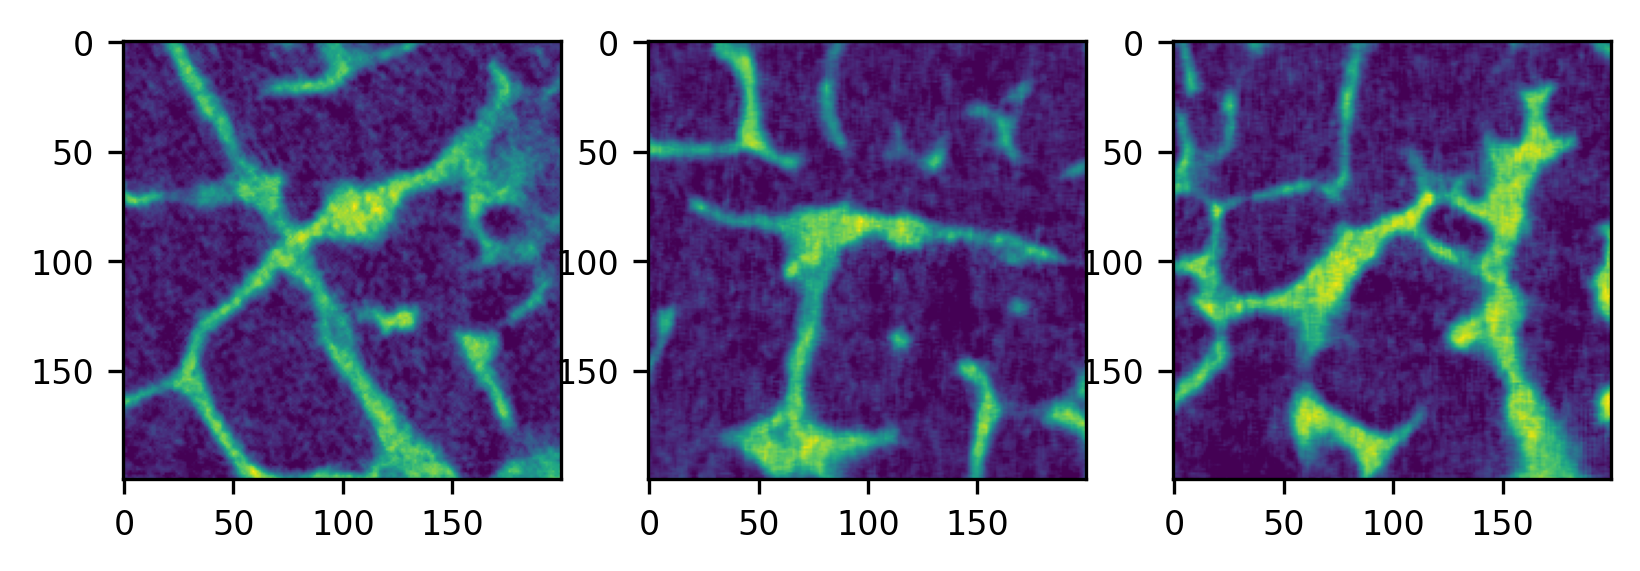

In [7]:
plot_midplanes(data_3D)
plt.show()

## Pre-processing
### Gaussian smooth

In [8]:
# data_3D = gaussian(data_3D, sigma=1, preserve_range=True)

### Crop

In [6]:
data_3D_crop = data_3D[0:50,0:50,0:50]

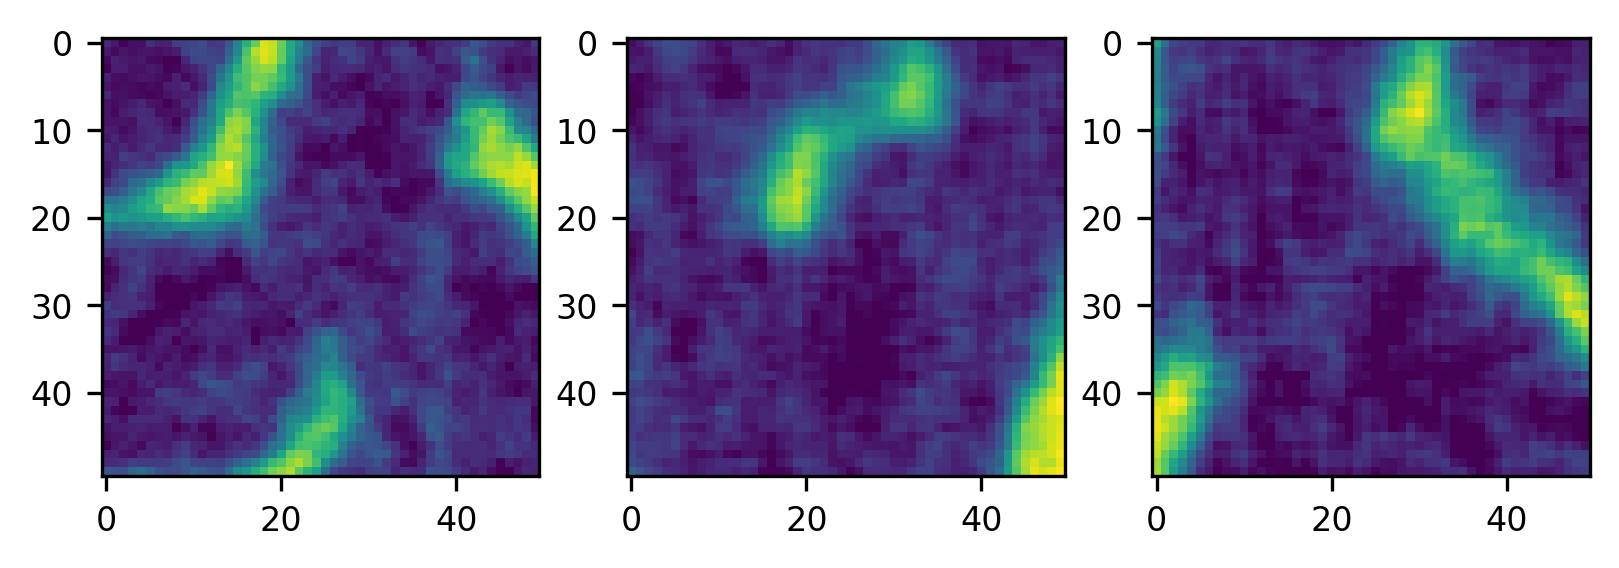

In [10]:
# Inspect again the dataset
# plot_midplanes(data_3D_crop, 10,10,10)
plot_midplanes(data_3D_crop)

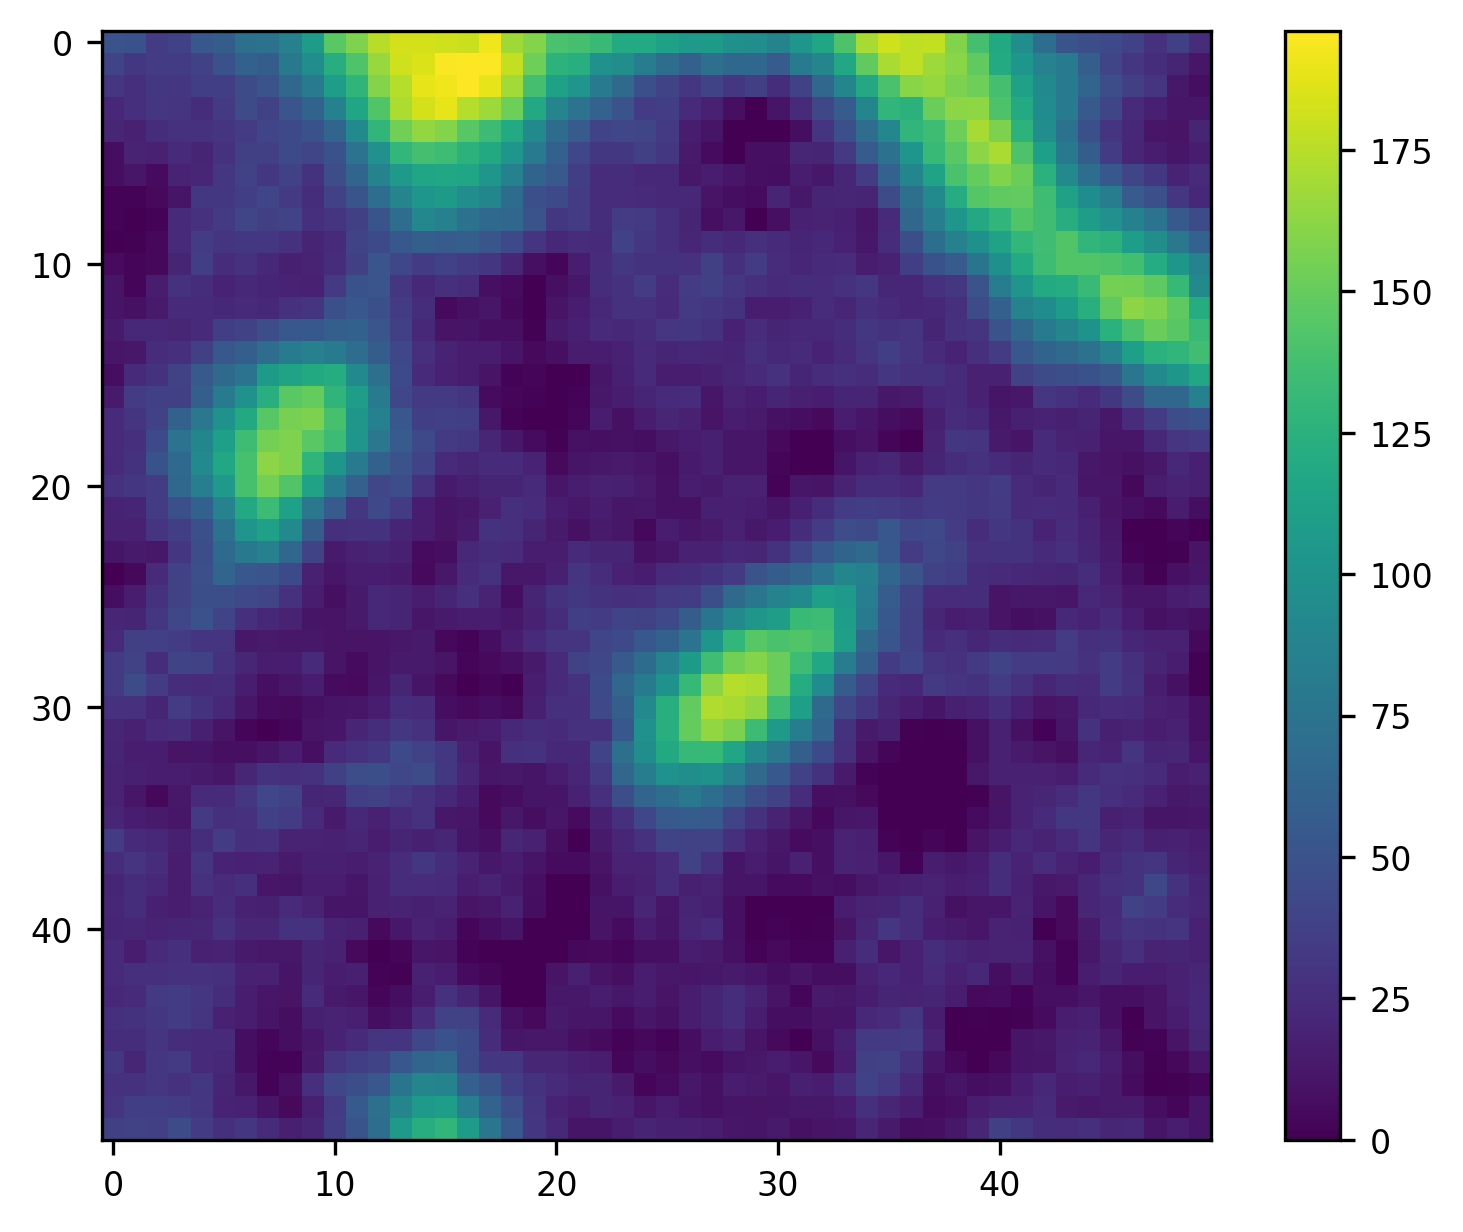

In [11]:
im = plt.imshow(data_3D_crop[0,:,:])
cbar = plt.colorbar(im)

### Thresholding


In [12]:
# use Otsu's method
T = threshold_otsu(data_3D)
print("Threshold: {}".format(T))

Threshold: 84


In [13]:
# # plot the input image histogram
# fig2, ax2 = plt.subplots()
# plt.hist(data_3D_crop[0,:,:].ravel(), bins=40)
# plt.show()

Apply the threshold

In [7]:
# BW = data_3D > T
BW = data_3D_crop >= 112 # 52?? from comparison with histology

Have a look at the binarized dataset

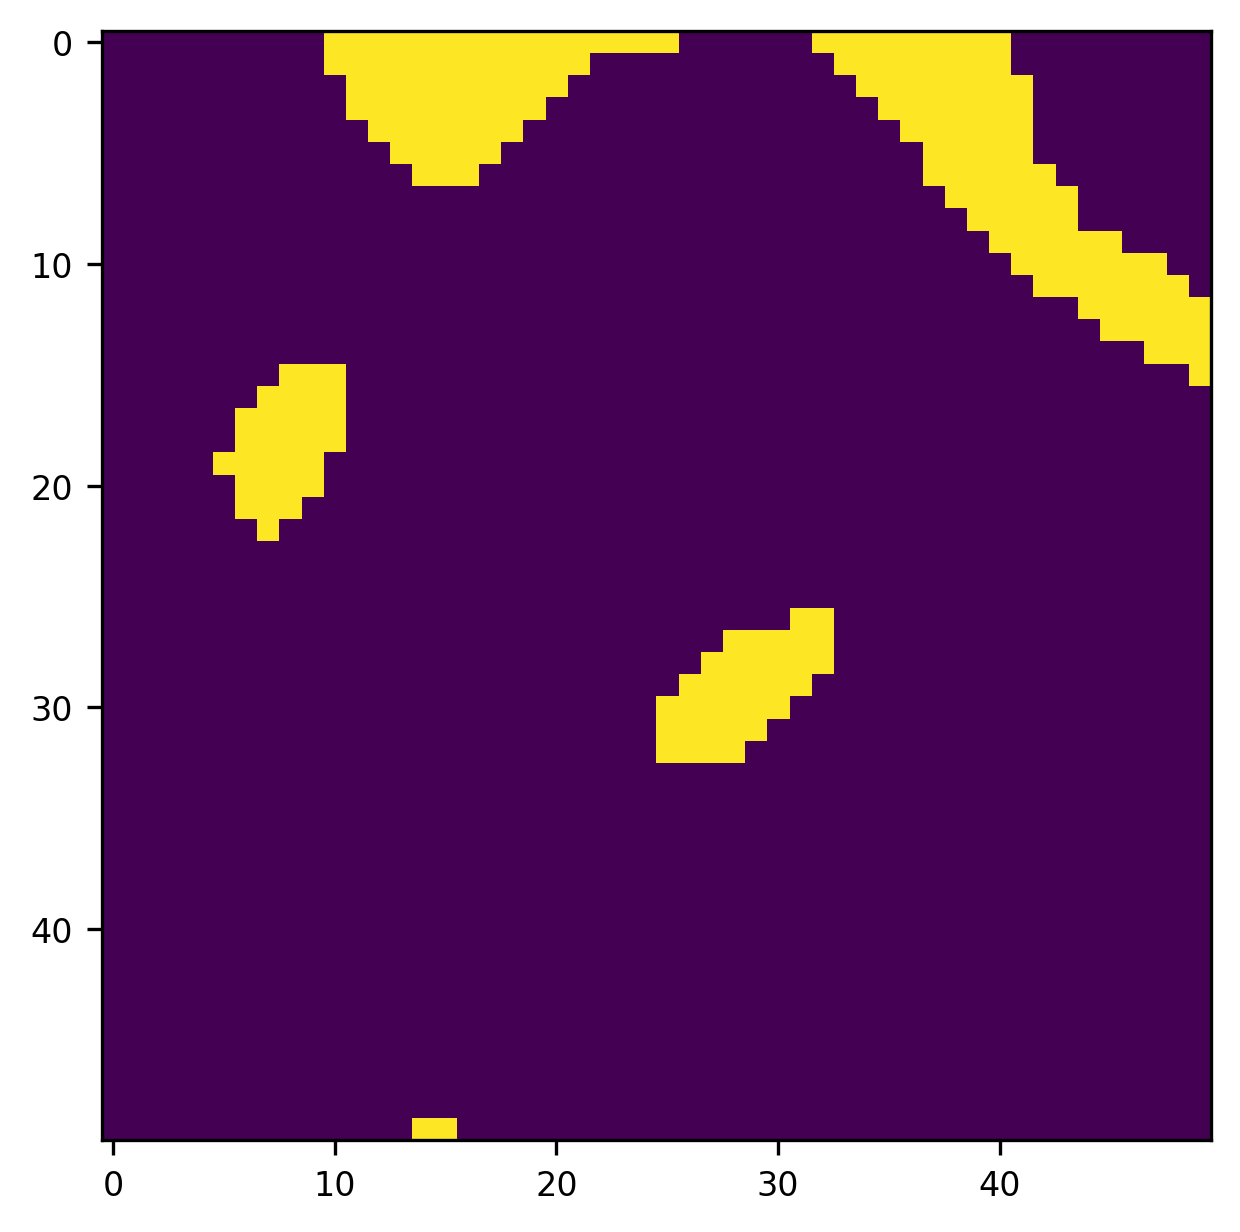

In [15]:
plt.imshow(BW[0,:,:])

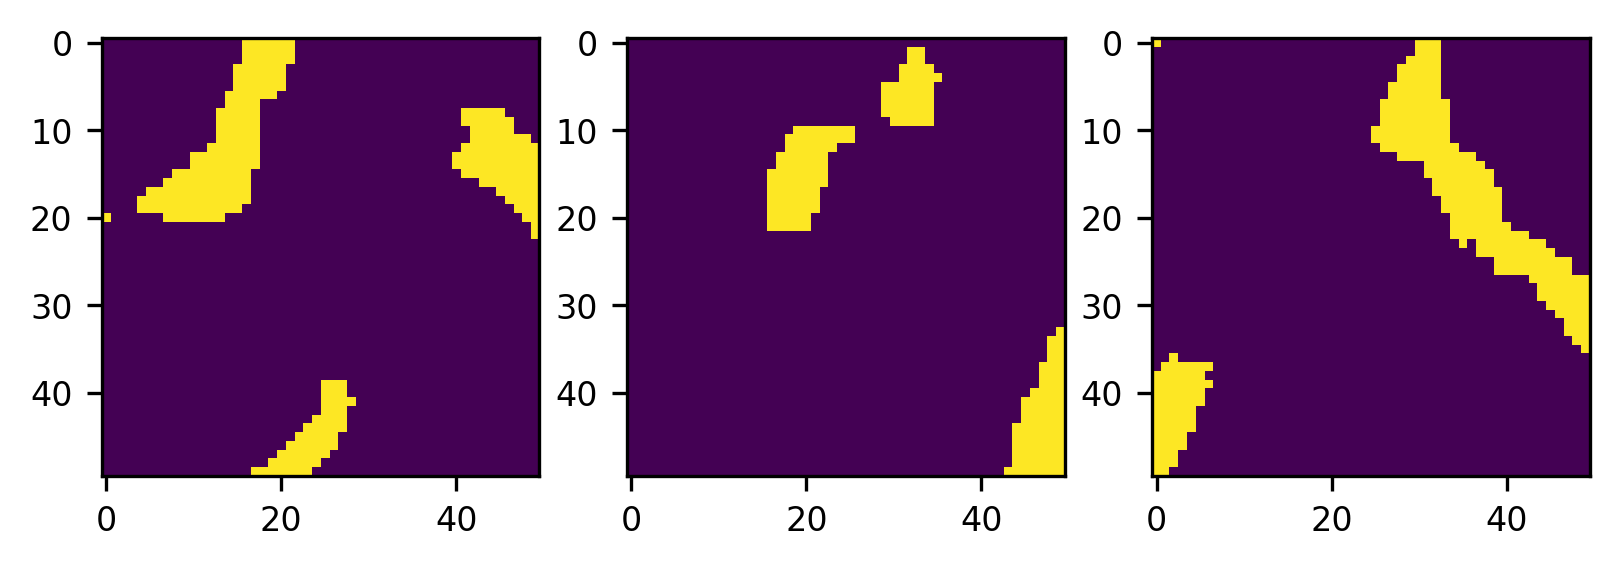

In [16]:
plot_midplanes(BW)
plt.show()

### Morphological close of binary image (optional)

In [17]:
# BW = morphology.closing(BW, morphology.ball(3))

### Detect largest isolated cluster of voxels

In [8]:
BW = remove_unconnected(BW)

### Distance transform from the image background

In [165]:
dist = ndimage.distance_transform_edt(BW)

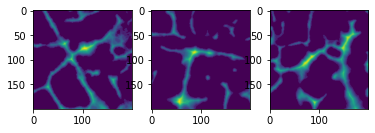

In [32]:
plot_midplanes(dist)

---
## Skeletonization with `skimage.skeletonize_3d`
https://github.com/seung-lab/cloud-volume/wiki/Advanced-Topic:-Skeletons

Invert the image

In [19]:
# inverseBW = invert(BW)

3D skeletonization with [scikit.skeletonization_3d]()

In [9]:
ske = skeletonize_3d(BW).astype(np.uint8)

Plot max-projs of the skeleton

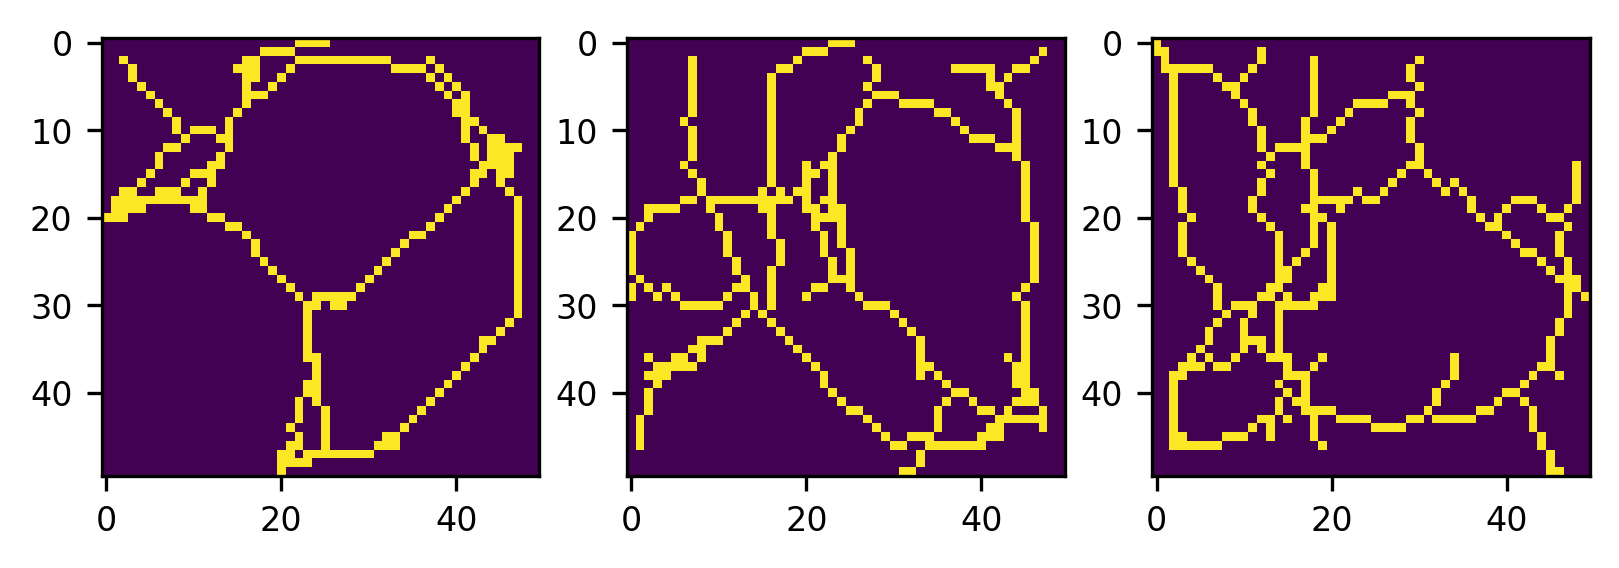

In [10]:
# plot_midplanes(ske)
plot_projections(ske)

Display with itkviewer

In [22]:
# # viewer = view(skeletonBW, ui_collapsed=True)
# viewer = view(ske, ui_collapsed=True)
# viewer.interpolation = False
# viewer
# view(ske)

Compute the medial axis (skeleton) and the distance transform

In [23]:
# skel, distance = medial_axis(BW, return_distance=True) # not working for 3D images!

---
### Compute graph from the skeleton using the [sknw](https://github.com/Image-Py/sknw) package

build graph from skeleton

In [11]:
graph = sknw.build_sknw(ske)

In [13]:
graph.number_of_nodes()

33

---
### Graph object contents:

ref for inspection of graph contents and methods:
[networkx](https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.edges.html)

- `graph.edges(i)` lists the connectivity of node `i` (i.e. all the arcs of the graph leaving node `i`)

> **_NOTE:_**  `graph.edges` corresponds to the graph arcs!

- `graph.nodes[i]` stores the coordinates of all voxels classified as graph node `i`. One graph node can be one or more voxels.
    - `graph.nodes[i]['pts']`: points identified as node `i` 
    - `graph.nodes[i]['o']`: origin of node `i` as average of `pts`
- `graph.degree(i)` reports the degree of connectivity of node `i` (i.e. number of arcs connected to node `i`
- `graph.adj[i][j]` reports the two fields `pts` and `weight` for the arc `i-j`
    - `graph.adj[i][j]['pts']` lists the coordinates of voxels belonging to the arc `i-j`. This is equivalent to the call `graph[i][j]['pts']`

For instance, print the connectivity of node `176`:

In [27]:
id = 17
graph.edges(id)

EdgeDataView([(17, 11), (17, 19), (17, 16)])

Print the coordinates of all points belonging to the graph arc between nodes `176` and `5`:

In [51]:
graph.nodes[5]['o

array([ 5,  9, 42], dtype=uint16)

In [29]:
# graph[0][5]['pts']

the coordinates of these nodes are stored in `graph.nodes`

---
#### Plotting the graph

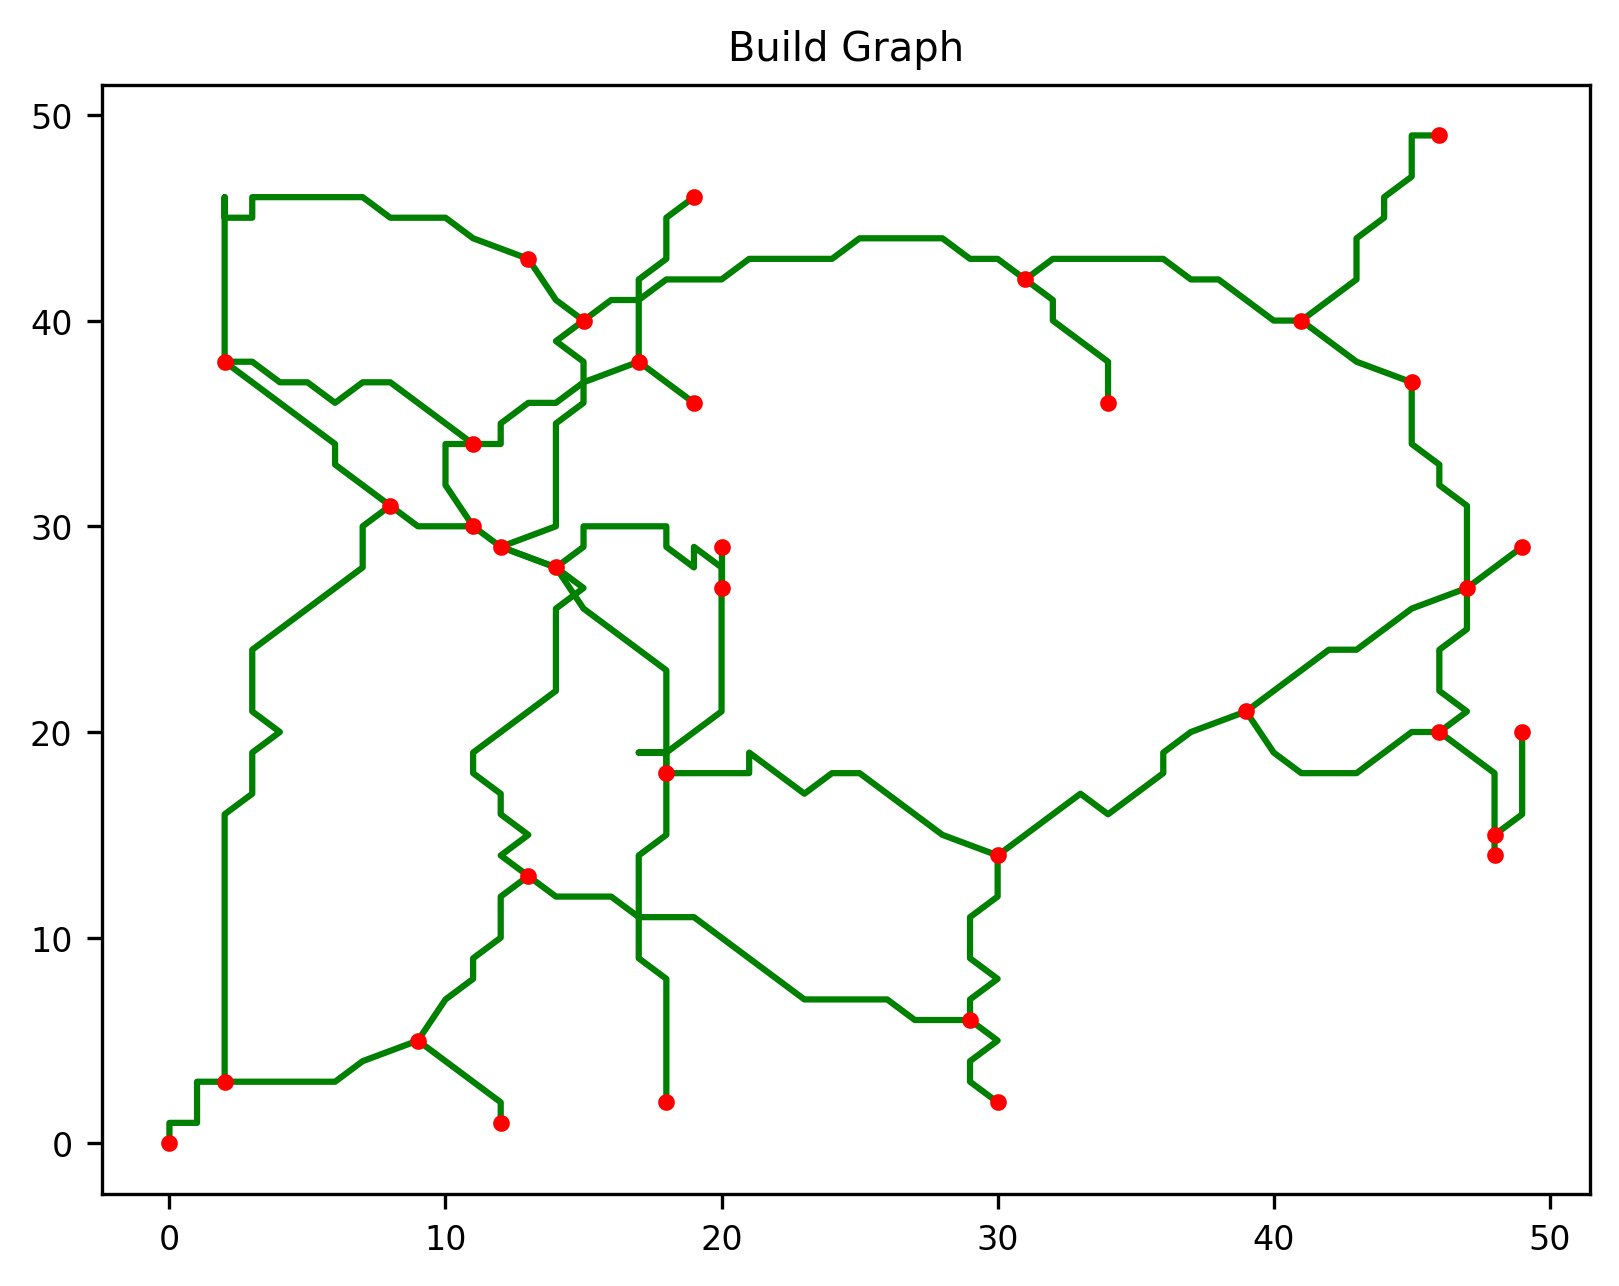

In [30]:
# draw edges by pts
for (s,e) in graph.edges():
    ps = graph[s][e]['pts']
    plt.plot(ps[:,1], ps[:,0], 'green')
    
# draw node by o
nodes = graph.nodes()
ps = np.array([nodes[i]['o'] for i in nodes])
plt.plot(ps[:,1], ps[:,0], 'r.')

# title and show
plt.title('Build Graph')
plt.show()

Plot the graph in 3D with
`network_plot_3D(graph, angle)`

/tmp/ipykernel_872482/2419563637.py:26: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(xi, yi, zi, c=colors[key], s=20+20*G.degree(key), edgecolors='k', alpha=0.7)


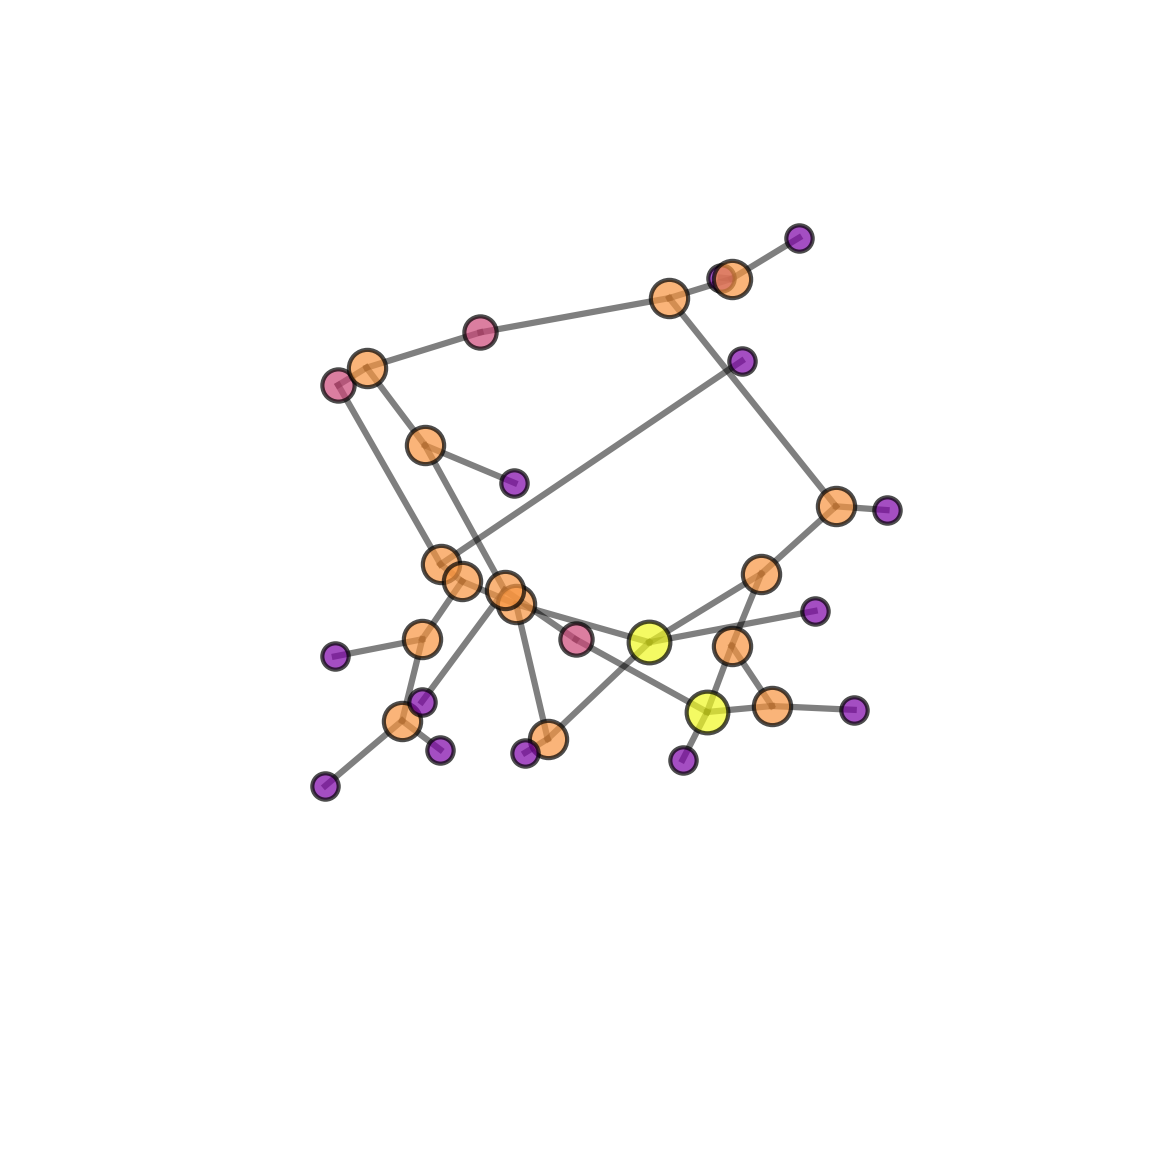

In [15]:
network_plot_3D(graph, 65)

---
## Assemble arrays for FE model creation
- `nodes: [ID, x, y, z]`
- `elements: [ID_n1, ID_n2]`
> **_NOTE:_**  Node indexes start from 1!

In [76]:
# initialize nodes array
nodes = np.zeros((graph.number_of_nodes(),4), dtype=float)
print(nodes.shape)

(33, 4)


In [77]:
for n in range(0,graph.number_of_nodes()):
    nodes[n, 0]  = n+1
    nodes[n, 1:] = graph.nodes[n]['o']

In [140]:
elements = np.array(list(graph.edges()))

In [159]:
th = np.zeros((elements.shape[0]))

In [199]:
# get max thickness of the arc
for n in range(0, len(th)):
    # print(n)
    voxels = graph[elements[int(n),0]][elements[int(n),1]]['pts']
    # print(voxels.shape)
    th_array = np.zeros((voxels.shape[0],1))
    count = 0
    for v in voxels:
        th_array[count] = dist[v[0], v[1], v[2]]
        count += 1
    th[n] = np.max(th_array)

## Add mid-point of each element:
- nodes: append mid-point node coordinates at the end of nodes array (n. of rows corresponiding to n. el will be added)
- elements: add third column corresponding to the row of the midpoint node in matrix nodes 

In [213]:
n1=0
n2=20
coords = np.array([nodes[n1,1:],
                   nodes[n2,1:]])

print(coords)
print(np.mean(coords, axis=0))


[[ 0.  0. 25.]
 [31.  8. 15.]]
[15.5  4.  20. ]


In [242]:
added_node_id = np.zeros((elements.shape[0],1))

In [243]:
added_node_coors = np.zeros((elements.shape[0],4))

In [247]:
# find mid node for each arc
new_e_count = nodes.shape[0]
for e in range(0,elements.shape[0]):
    n1 = elements[e,0]
    n2 = elements[e,1]
    
    coords = np.array([nodes[n1,1:],
                       nodes[n2,1:]])
    
    n3 = np.mean(coords, axis=0)
    
    added_node_id[e] = new_e_count
    added_node_coors[e,0] = new_e_count+1
    added_node_coors[e,1:] = n3
    new_e_count += 1

In [248]:
nodes_new = np.concatenate((nodes, added_node_coors), axis=0)

In [250]:
elements_new = np.concatenate((elements, added_node_id), axis=1)

In [251]:
elements_new

array([[ 0., 20., 33.],
       [ 1.,  5., 34.],
       [ 2., 10., 35.],
       [ 3.,  6., 36.],
       [ 4.,  5., 37.],
       [ 5.,  7., 38.],
       [ 6.,  7., 39.],
       [ 6.,  8., 40.],
       [ 7., 16., 41.],
       [ 8., 10., 42.],
       [ 8., 11., 43.],
       [ 9., 12., 44.],
       [10., 15., 45.],
       [10., 14., 46.],
       [11., 12., 47.],
       [11., 13., 48.],
       [12., 13., 49.],
       [13., 18., 50.],
       [13., 24., 51.],
       [14., 15., 52.],
       [14., 19., 53.],
       [15., 17., 54.],
       [16., 27., 55.],
       [19., 20., 56.],
       [19., 21., 57.],
       [20., 29., 58.],
       [21., 26., 59.],
       [21., 25., 60.],
       [22., 26., 61.],
       [23., 30., 62.],
       [24., 28., 63.],
       [26., 31., 64.],
       [27., 29., 65.],
       [27., 30., 66.],
       [28., 30., 67.],
       [28., 32., 68.]])

## Write `.INP` output file

In [ ]:
# write Abaqus input given arrays of beam nodes and elements
# write ABAQUS *.inp output file ############################################
def abaqus_beam_model(nodes, elements, fileout='pippo.inp')
    # open ABAQUS *.INP output file
    INP = open(fileout, 'w')

    # HEADER
    INP.write('** ---------------------------------------------------------\n')
    INP.write('** Abaqus .INP file written by ciclope
    INP.write('** ---------------------------------------------------------\n')

    # NODE COORDINATES
    # logging.info('Writing model nodes to INP file')
    INP.write('** Node coordinates from input model\n')
    INP.write('*NODE\n')

    # write only the existing nodes
    existing_nodes = np.unique(mesh.cells_dict["hexahedron"])
    for node in existing_nodes:
        INP.write('{0:10d}, {n[0]:12.6f}, {n[1]:12.6f}, {n[2]:12.6f}\n'.format(node, n=mesh.points[node]))

    # ELEMENTS AND ELEMENT SETS
    n_els = 0
    # logging.info('Writing model elements to INP file')
    INP.write('** Elements and Element sets from input model\n')
    i = 0

    # for each existing model Grey Value
    for GV in existing_GV:
        # compose element SET definition string and write to output file
        elset_str = 'SET' + str(int(GV))
        INP.write('*ELEMENT, TYPE={0}, ELSET={1}\n'.format(eltype, elset_str))

        # for each cell with that Grey Value
        for cell in np.where(cell_GV == GV)[0]:
            # write cell index followed by a list of its nodes
            INP.write('{0},{n[0]},{n[1]},{n[2]},{n[3]},{n[4]},{n[5]},{n[6]},{n[7]}\n'.format(cell+1, n=mesh.cells[0][1][cell]))

    # NODE SETS
    if 'NSET' in keywords:
        INP.write('** Additional nset from voxel model. New generated nsets are:\n')
        INP.write('** {}, \n'.format(*list(mesh.point_sets)))

        # write node set string
        for nsetName in list(mesh.point_sets):
            INP.write('*NSET, NSET={0}\n'.format(nsetName))
            CR = 1 # carriage return
            # write node set indexes in lines of 10
            for node_i in mesh.point_sets[nsetName]:
                if CR < 10:
                    INP.write('{},'.format(node_i))
                else:
                    INP.write('{}\n'.format(node_i))
                    CR = 0
                CR = CR + 1
            INP.write('\n')
        logging.info('Additional nodes sets generated: {}'.format(list(mesh.point_sets)))

    # CELL SETS
    if 'ELSET' in keywords:
        INP.write('** Additional elset from voxel model. New generated elsets are:\n')
        INP.write('** {}, \n'.format(*list(mesh.cell_sets)))

        # write cell set string
        for csetName in list(mesh.cell_sets):
            INP.write('*ELSET, ELSET={}\n'.format(csetName))
            CR = 1 # carriage return

            # write cells set indexes in lines of 10
            for cell_i in mesh.cell_sets[csetName]:
                if CR < 10:
                    INP.write('{},'.format(cell_i))
                else:
                    INP.write('{}\n'.format(cell_i))
                    CR = 0
                CR = CR + 1
            INP.write('\n')
        logging.info('Additional cell sets generated: {}'.format(list(mesh.cell_sets)))

    # MATERIAL MAPPING
    if 'PROPERTY' in keywords:
        logging.info('User material properties defined. Writing material property section of INP file')
        INP.write('** User material property definition:\n')
        INP.write('** internal variables are: "SetName", "MatName", "GV"\n')

        n_propfile = 0
        for input_property in matprop["file"]:
            # open material property template file
            try:
                PROPfile = open(input_property, 'r')
            except IOError('Material property file not found'):
                exit(1)

            lines = PROPfile.readlines()
            # for each GV corresponding to an existing material index
            for GV in existing_GV:

                # if the GV belongs to the GVrange assigned to the specific material property
                if prop_GV[n_propfile][0] <= GV <= prop_GV[n_propfile][1]:
                    matset_str = 'SET' + str(GV)

                    for line in lines:
                        line = line.replace('\n', '')

                        # copy comment lines as they are
                        if line.startswith('**'):
                            INP.write('{}\n'.format(line))
                            continue

                        # replace keyword 'SetName' and assign current material to the corresponding (by GV) elset
                        if 'SetName' in line:
                            line = line.replace('SetName', matset_str)

                        # replace keyword 'MatName' and create new material flag for current GV
                        if 'MatName' in line:
                            line = line.replace('MatName', 'MAT' + matset_str)

                        # replace keyword 'GV' with current GV and evaluate expression for each material property
                        if 'GV' in line:
                            prop_strings = line.split(',')
                            prop_n = 0
                            for prop in prop_strings:
                                if 'GV' in prop:
                                    INP.write('{}'.format(eval(prop)))
                                else:
                                    INP.write('{}'.format(prop))
                                if prop_n < len(prop_strings) - 1:
                                    INP.write(',')
                                prop_n = prop_n + 1

                            INP.write('\n')
                        else:
                            # copy line as is
                            INP.write('{}\n'.format(line))
            PROPfile.close()
            n_propfile = n_propfile + 1

    # BOUNDARY CONDITIONS AND ANALYSIS DEFINITION
    # Open Abaqus analysis template file
    try:
        template = open(templatefile, 'r')
    except IOError('Abaqus template file {} not found.'.format(templatefile)):
        exit(1)
    logging.info('Reading Abaqus template file {}'.format(templatefile))

    # copy line by line info on model solution and boundary conditions from Abaqus analysis template file
    for line in template.readlines():

        if refnode is not None:
            # replace keywords 'refnodeX', 'refnodeY' and 'refnodeZ' with refnode coordinates
            line = line.replace('refnodeX', str(round(refnode[0], 4)))
            line = line.replace('refnodeY', str(round(refnode[1], 4)))
            line = line.replace('refnodeZ', str(round(refnode[2], 4)))

        # write line to output Abaqus file
        INP.write('{}'.format(line))

    template.close()
    INP.close()
    logging.info('Model with {0} nodes and {1} elements written to file {fname}'.format(len(mesh.points), len(mesh.cells[0]), fname=fileout))

    return



---
## Trabecular local thickness

The local diameter of single trabeculae can be measured by combining the skeleton and the distance transform to the background [Gouillart_2017](https://hal.archives-ouvertes.fr/hal-01448271).

- Gouillart, Emmanuelle, Juan Nunez-Iglesias, and Stéfan van Der Walt. 2017. “Analyzing Microtomography Data with Python and the Scikit-Image Library.” Advanced Structural and Chemical Imaging 2: 18. https://doi.org/10.1186/s40679-016-0031-0.

---
> ## **Update: ITK has an [ITKThickness3D](https://github.com/T4mmi/ITKThickness3D) Python module for both skeleonization and local thickness tested for trabecular bone. Consider migrating to this module!!**
> - **Binary thinning** provides a 1 pixel-thin wire skeleton using an efficient curve thinning algorithm. The thinning algorithm used in this module comes from the Insight Journal article:
    - Homann H., Implementation of a 3D thinning algorithm. The Insight Journal - 2007 July - December. http://hdl.handle.net/1926/1292; http://insight-journal.org/browse/publication/181
> - **Medial thickness** computes twice the shortest distance to the outter shell along the medial axis of the object (i.e. diameter of the local maximal fitting sphere).

### Mask the distance transform with skeleton image
Convert the skeleton to a mask

In [43]:
ske01 = ciclope.utils.recon_utils.to01(ske).astype(bool)

Masking operation

In [53]:
masked = dist.copy().astype('uint8')

In [54]:
masked[~ske01] = 0

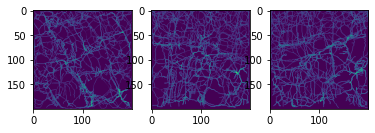

In [55]:
plot_projections(masked)

Write skeleton image as stack of TIFFs for inspection

In [51]:
import dxchange

In [56]:
dxchange.write_tiff_stack(masked, "/home/gianthk/PycharmProjects/CT2FE/test_data/LHDL/3155_D_4_bc/results/skeleton/slice.tiff")

Visualize in ParaView

![skeleton](./../../test_data/LHDL/3155_D_4_bc/results/skeleton.png)

---
### [Skeletor](https://pypi.org/project/skeletor/) turns meshes into skeletons

In [243]:
#pip3 install skeletor
import skeletor as sk
mesh = sk.example_mesh()
fixed = sk.pre.fix_mesh(mesh, remove_disconnected=5, inplace=False)
skel = sk.skeletonize.by_wavefront(fixed, waves=1, step_size=1)
#skel = skeletor.skeletonize.by_teasar()
#Skeleton(BW, mesh=mesn, mesh_map=None, method=None)

Skeletonizing:   0%|          | 0/6213 [00:00<?, ?it/s]